# Métricas para la evaluación del desempeño de métodos de *Virtual Screening*

**Esta libreta muestra una síntesis de los métodos de evaluación de desempeño de VS mencionados por [Truchon y Bayley (2007)](https://pubs.acs.org/doi/10.1021/ci600426e).**

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(r'..')

In [2]:
from modules.plotting_metrics import PlotMetric
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Carga de los resultados de DOcking para CSAR y DUD

In [3]:
data_dir = '../data'
# Resultados CSAR
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
df_vina_results   = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
df_vinardo_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)
# Resultados DUD
patho_to_json_vrd8_file = glob.glob((os.path.join('..', 'data', 
                       'vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv')))[0]
df_vinardo_DUD = pd.read_csv(patho_to_json_vrd8_file, index_col=0)

In [4]:
# Estos scores son para ejemplificar la ejecución de las métricas
pdb_id = '2vv9'
y_score_vrd = np.array(df_vinardo_results[pdb_id])
y_score_vina = np.array(df_vina_results[pdb_id])
y_score_ad4_LE = np.array(df_ad4_results_LE[pdb_id])
y_score_ad4_LC = np.array(df_ad4_results_LC[pdb_id])
scores_csar = {"AD4 LE": y_score_ad4_LE, "AD4 LC": y_score_ad4_LC, 
               "Vina": y_score_vina, "Vinardo": y_score_vrd}

In [5]:
y_score_vrd_DUD = np.array(df_vinardo_DUD[pdb_id])
scores_dud = {'VinardoDUD': y_score_vrd_DUD}

### Los tres casos mencionados por Truchon y Bayly

- **Caso 1**: La mitad de los activos se ubica al principio del *ranking*, mientras que la otra mitad se encuentra al final.
- **Caso 2**: Todos los activos se distribuyen justo a la mitad del ranking.
- **Caso 3**: Los activos e inactivos se encuentran uniformemente distribuidos.

### Casos aplicados a los datasets de CSAR y DUD para la proteína CDK2

**CSAR**:
> CSAR posee 111 moléculas, de las cuales 26 son activas, con lo cual el $R_a$ de CSAR es de $26/111 = 2.36$.

In [6]:
N_csar = 111
n_csar = 26
# Creamos el arreglo de valores verdaderos:
y_true_csar = np.array(df_vina_results.ActiveInactive == "Active", dtype=int)
# Scores obtenidos con las herramientas de docking
csar_dockings = PlotMetric(y_true = y_true_csar, y_pred_dict = scores_csar, decreasing=True)

**DUD:**
> DUD posee  2146 moléculas de las cuales 72 son activas; $R_a = 72/2146 = 0.033$.

In [7]:
N_dud = 2146
n_dud = 72
y_true_dud = np.array(df_vinardo_DUD.Actividad == "Active", dtype=int)
# Scores obtenidos con las herramientas de docking
dud_dockings = PlotMetric(y_true = y_true_dud, y_pred_dict = scores_dud, decreasing=True)

Las variables `y_true_csar` y `y_true_dud` corresponden a un arreglo binario de $N$ elementos que corresponden al número total de moléculas, donde las moléculas activas son etiquetadas con le valor $1$ y las inactivas con $0$. El número totoal de moléculas activas en cada arreglo es $n$.

### Generación de los valores predichos para simular los tres casos de ranking

In [8]:
from truchon_2006_3_ranking_cases import get_three_ranking_cases

#### Casos aplicados a CSAR

In [9]:
# Generamos los tres casos de CSAR
csar_cases_preds = get_three_ranking_cases(y_true_csar, include_optimal = True)
csar_cases = PlotMetric(y_true = y_true_csar, y_pred_dict = csar_cases_preds)

#### Visualizamos la distribución de los activos en cada caso
Cada barra representa un ranking correspondiente a cada caso, en color rojo se muestran los ligandos activos (verdaderos positivos).

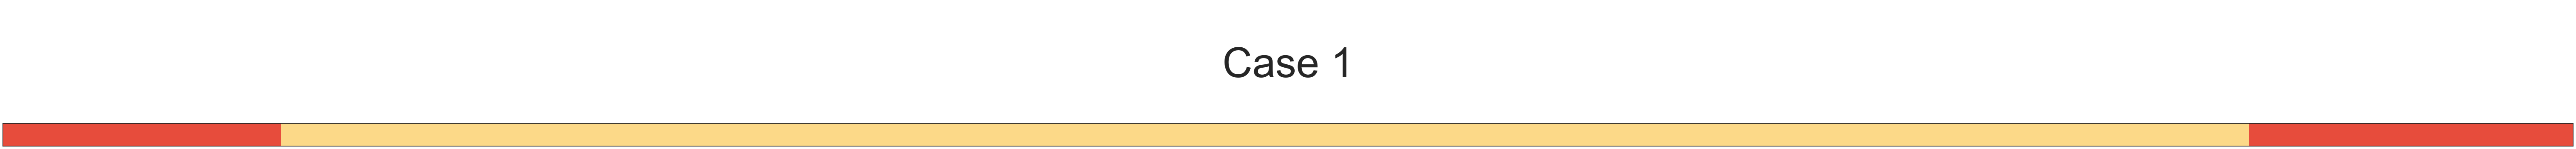

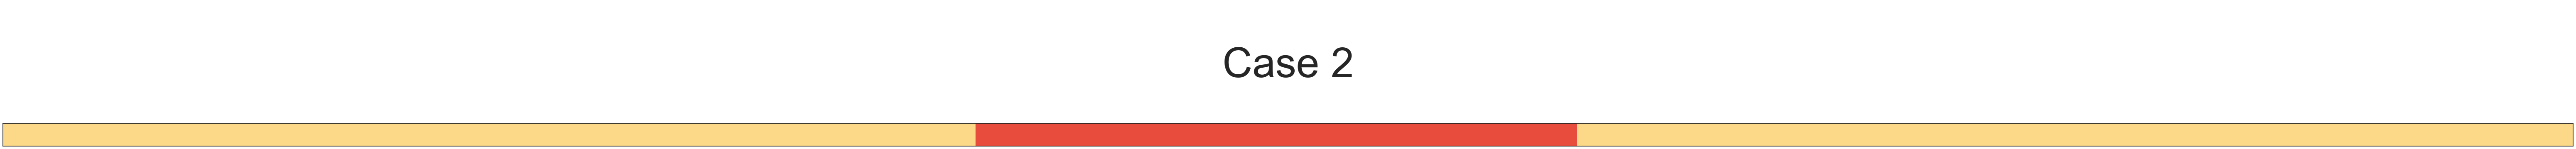

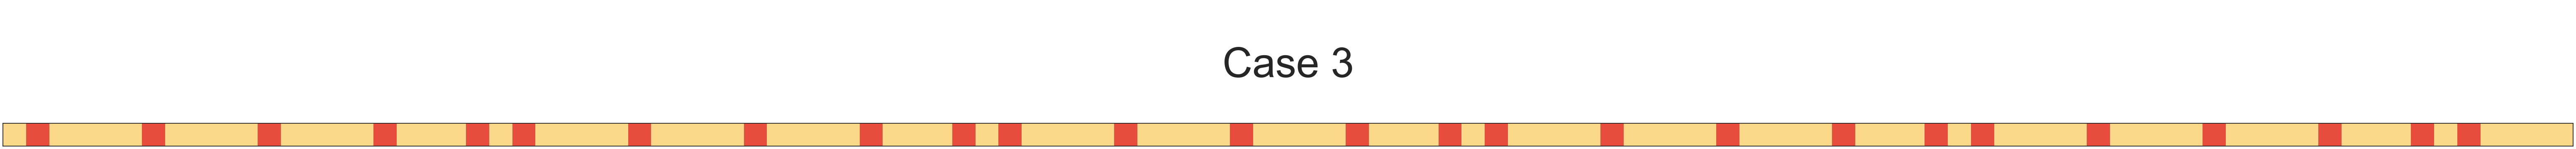

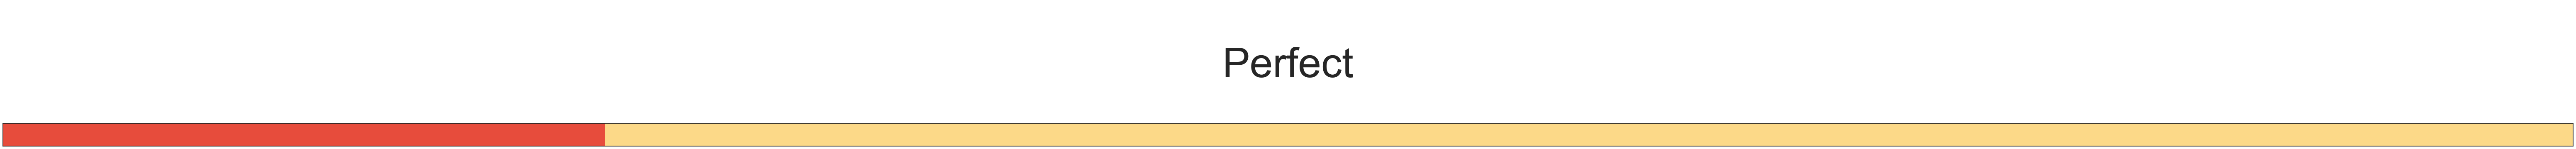

In [10]:
# Visualización de los rankings
csar_cases.plot_actives_distribution()

#### Casos aplicados a DUD

In [11]:
dud_cases_preds = get_three_ranking_cases(y_true_dud, include_optimal = True)
dud_cases = PlotMetric(y_true = y_true_dud, y_pred_dict = dud_cases_preds)

No se muestra la visualización de DUD debido al número de moléculas en el dataset genera una imagen demasiado grande y no puede ser mostrada dentro de este notebook.

### Notación inicial:

Los rankings de las moléculas obtenidos por una herramiento o método de scoring determinan una función de distribución de probabilidad (PDF) $f(x)$, a partir de ella se obtiene la función de distribución acumulada (CDF) $F(x)$, que es el área bajo la curva de $f(x)$: $F(x) = \int_{0}^{1} f(x)dx$.

La distribución de los activos en el *ranking* dado, y la $CDF$ del mismo, permiten a las métricas presentadas a continuación valorar el desempeño de la herrameienta que generó el *ranking*.

- $N$: Número total de moléculas
- $n$: Número de moléculas activas
- $R_a = n/N$: Proporción de activos en el ranking k
- $k = (k_1, k_2, ..., k_N)$: Lista de scores ordenados, donde la posición $k_i$ corresponde al mejor score.
- $x = k/N = (x_1, x_2, ..., x_N)$: Lista normalizada del ranking $k$.

## Métricas comunmente usadas para evaluar los resultados de un *Virtual Screening*

***
## Área Under the Accumulation Curve

- La curva de Acumulación equivale a la función de distribución acumulada (CDF) de los activos en el *ranking* normalizado; $F_a(x)$.
- $F_a(x)$ corresponde a la probabilidad de encontrar una molécula activa a una posición $x_i$ del ranking normalizado $x$. Es decir, corresponde a la sensibilidad ($TP/P$) acumulada hasta la posición $k_i$.
- $AUAC$ es el área bajo la curva de $F_a(x)$ en función de ($x$), con lo cual:

$$
\begin{aligned}
AUAC = \int _{0}^{1} F_a(x)
\end{aligned}
$$

- $AUAC$ se puede interpretar como la probabilidad de que un activo, seleccionado de una **CFD** (definida por el *ranking*), sea *rankeado* antes de una molécula seleccionada aleatoriamente en una distribución uniforme ($f(x)=1$). De esta relación se desprende lo siguiente:

$$
\begin{aligned}
AUAC = 1 - \langle x \rangle _a
\end{aligned}
$$
> donde $\langle x \rangle _a$ es la media del rango normalizado de los activos.

- Por lo anterior, se dice que $AUAC$ es una métrica sin peso, debido a que, independientemente de su posición en el ranking, una activo tendrá el mismo peso que el resto.
- $AUAC$ no puede determinar cual de los tres casos propuestos es mejor.

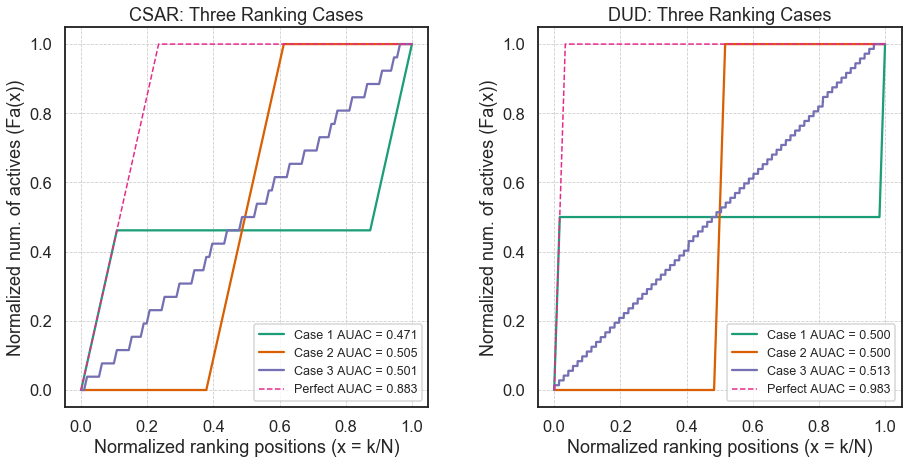

In [15]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_cases.plot_auac(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                     fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_auac(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                    fontsize='x-small', show_by_itself = False)
plt.show();

In [16]:
print('AUAC CSAR')
csar_cases.format_metric_results('auac', transposed=False)
print('AUAC DUD')
dud_cases.format_metric_results('auac', transposed=False)

AUAC CSAR


,Case 1,Case 2,Case 3,Perfect
AUAC,0.471,0.505,0.501,0.883


AUAC DUD


,Case 1,Case 2,Case 3,Perfect
AUAC,0.5,0.5,0.513,0.983


#### AUAC con los resultados de docking

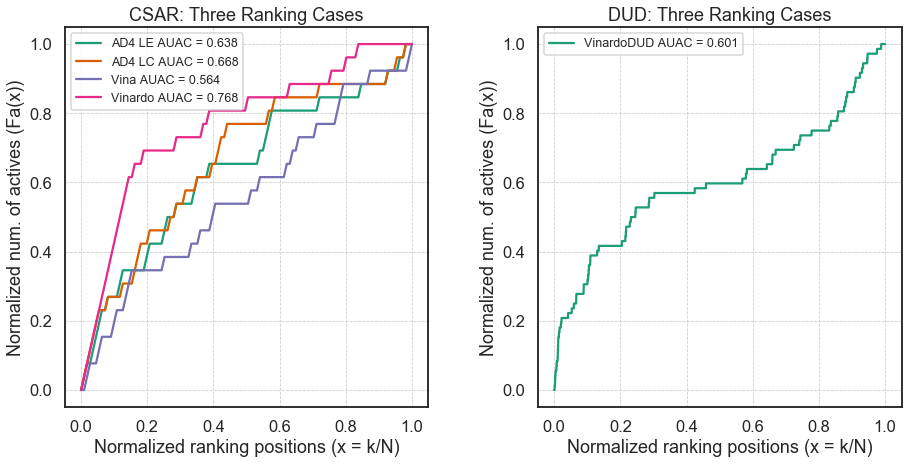

In [17]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_dockings.plot_auac(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                     fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_auac(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                    fontsize='x-small', show_by_itself = False)
plt.show();

**NOTA**:

***
## ROC-AUC

- Es una de las métricas más usadas para evaluar el desempeño de un VS.

- El valor de AUC de ROC va de 0 (peor desempeño) a 1 (mejor desempeño). Y cuando el AUC = 0.5, el ranking es equivalente a una selacción aleatoria entre activos e inactivos, mostrando una distribución uniforme entre estas dos clases.

- El valor del AUC-ROC puede interpretarse como la probabilidad de un activo sea encontrado antes que un inactivo en el *ranking* dado. Con lo cual, de forma continua se calcula de la siguiente manera:

> $
\begin{aligned}
ROC = \int _{0}^{1} F_a(x) \dot f_i(x) dx
\end{aligned}
$

> donde $f_i(x)$ es la PDF de inactivos en el *ranking*. Es decir, el $AUC ROC$ se obtiene a partir del producto de la CDF de los activos por la PDF de los inactivos.
- A diferencia de $AUAC$, aquí $f(x) = f_i(x) \neq 1$.


De forma numérica, es calculado de la siguiente manera (para *rankings* de scores):

> $
\begin{aligned}
ROC = \frac{1}{n(N-n)}\sum_{k = 2}^{N}F_a (k) *[F_i(k) - F_i(k - 1)] 
\end{aligned}
$

> donde $n$ es el número de moléculas activas (Positivos), $N$ es el total de moléculas evaluadas, $F_a(k)$ y $F_i(k)$ es la cuenta acumulada de activos e inactivos, respectivamente, hasta la posición $k$ del ranking. 

El valor normalizado de $F_a(k)$ es $F_a(x) = F_a(k) / n$. Es decir, $F_a(k)$ es la **tasa de verdaderos positivos o Sensibilidad** ($TP/P$). Por su parte, $F_i(x) = F_i(k) / (N-n)$, corresponde a la **tasa de falsos positivos** ($FP/N$).

> $
\begin{aligned}
ROC  = \sum_{i = 2}^{N} F_a (x_i) *[F_i(x_{i}) - F_i(x_{i-1})] \\
     = \sum_{k = 2}^{N} TPR_{k} * (FPR_{k} - FPR_{k-1}) \\
\end{aligned}
$

> donde $TPR_k = \frac{F_a(k)}{n}$ y $FPR_k = \frac{F_i(k)}{N-n}$ son la tasa de verdaderos positivos y la tasea falsos positivos hasta la posición $k$ del *ranking*, respectivamente.

- En la práctiva, lo anterior equivale a pensar que, al ir recorriendo cada posición $k$ del rango, cuando el delta de $\Delta FPR_k$ es igual a 0, $TPR_k$ aumenta $1/n$, pero el $AUC$ se mantiene constante. Y cuando $\Delta FPR_k \neq 0$, implica que el $FPR$ aumenta y nos movemos un paso (de tamaño $1/(N-n)$), lo que aumenta el valor de AUC; $AUC_k = AUC_{k-1} + (1/(N-n)) * TPR_k$.

- **ROC** no puede discriminar entre los tres casos propuestos.

#### ROC con los tres casos

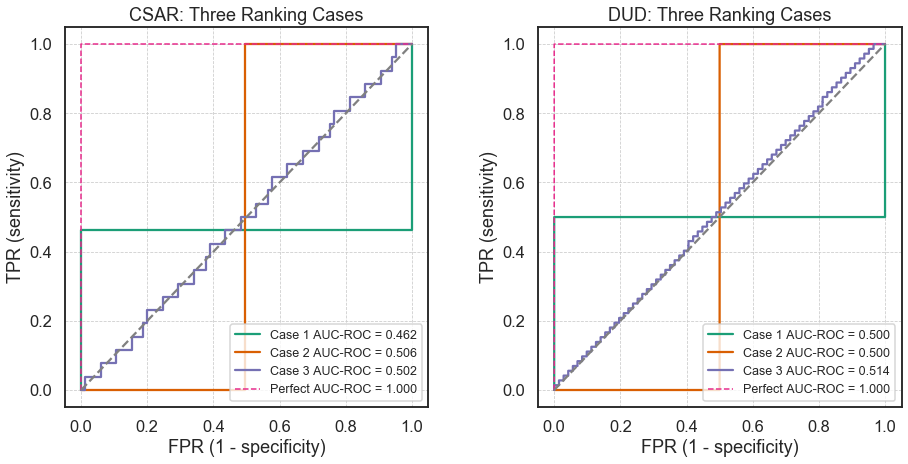

In [12]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_cases.plot_roc_auc(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                        fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_roc_auc(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.show();

In [13]:
print('ROC-AUC CSAR')
csar_cases.format_metric_results('roc_auc', transposed=False)
print('ROC-AUC DUD')
dud_cases.format_metric_results('roc_auc', transposed=False)

ROC-AUC CSAR


,Case 1,Case 2,Case 3,Perfect
ROC AUC,0.462,0.506,0.502,1.0


ROC-AUC DUD


,Case 1,Case 2,Case 3,Perfect
ROC AUC,0.5,0.5,0.514,1.0


#### ROC con los resultados de docking

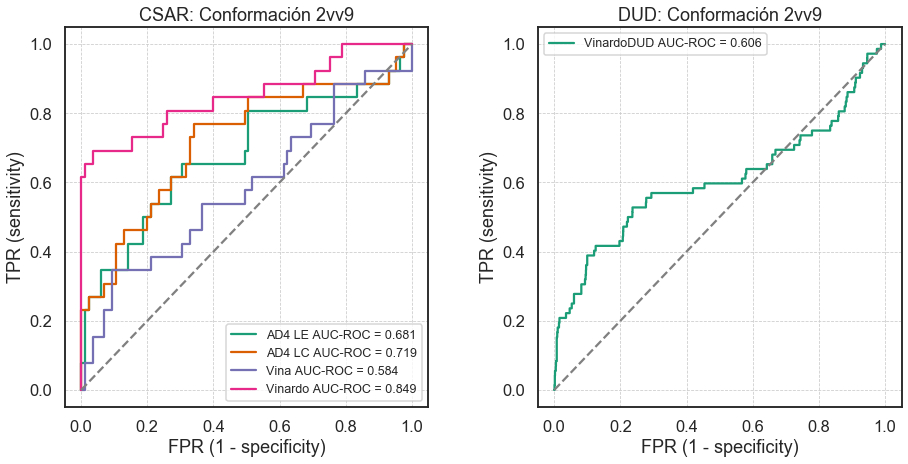

In [14]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_dockings.plot_roc_auc(title='CSAR: Conformación 2vv9',
                        fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_roc_auc(title='DUD: Conformación 2vv9',
                       fontsize='x-small', show_by_itself = False)
plt.show();

### Desventajas de ROC-AUC

- ROC-AUC no es una buena métrica para el VS, pues no permite abordar el problema de '*early recognition*'. Es decir, al tomar en cuenta toda la distribución de activos en el *ranking*, ROC-AUC no es capaz de distinguir *rankings* que podrían ser más convenientes en procedimiento de VS, donde la prioridad no es realmente rankear todos los posibles activos en la primer parte del ranking, sino garantizar que al menos una pequeña proporción de los activos quede al principio (en el *top*) del *ranking*. Pues, en la práctica, sólo una pequeña proporción de los compuestos rankeados será evaluada experimentalmente.
- Turchon y Bayly muestran además que en realidad si hay una dependencia de la métrica con respecto a la proporción de activos/inactivos.

# Precision and Recall Curve

- La Curva de Presición y Sensibilidad, y su área bajo la curva (AUC[PR]), no es abordada por Truchon y Bayley. Sin embargo, es mecionada por otros autores (Liu, *et al.*, 2019) como una alternativa para medir el desempeño del VS.
- Es recomendado para problemas con inbalance de clases.
- Se suele utilizar para visualizar el *trade-off* entre la precisión y la sensibilidad de un clasificador binario.

- El AUC es dependiente de $R_a$. Y en una distribución aleatoria el valor de la precisión ($TP/(TP + FP)$) decae hasta $R_a$ cuando la Sensibilidad ($TP/P$) tiende a 1.0.
- $AUC[PR]$ sí logra discriminar entre los tres casos mencionados por Truchon y Bayley (2007).

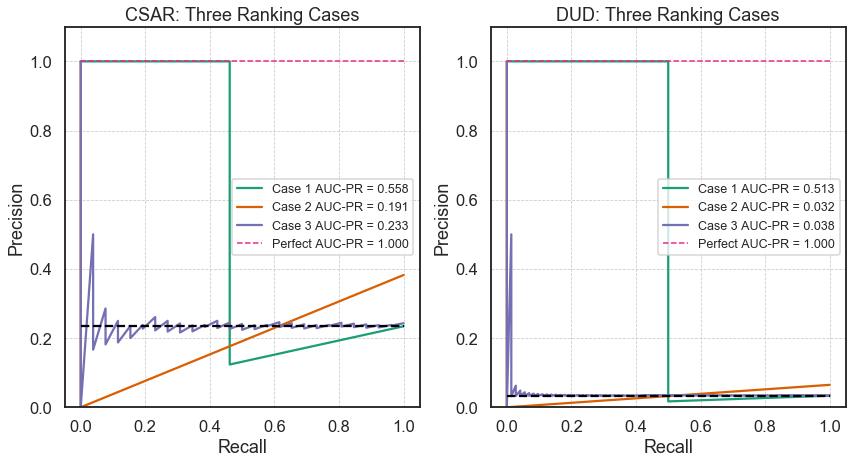

In [18]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_pr_auc(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_pr_auc(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

In [19]:
print('Precision/Recall AUC CSAR')
csar_cases.format_metric_results('pr_auc', transposed=False)
print('Precision/Recall DUD')
dud_cases.format_metric_results('pr_auc', transposed=False)

Precision/Recall AUC CSAR


,Case 1,Case 2,Case 3,Perfect
PR AUC,0.558,0.191,0.233,1.0


Precision/Recall DUD


,Case 1,Case 2,Case 3,Perfect
PR AUC,0.513,0.032,0.038,1.0


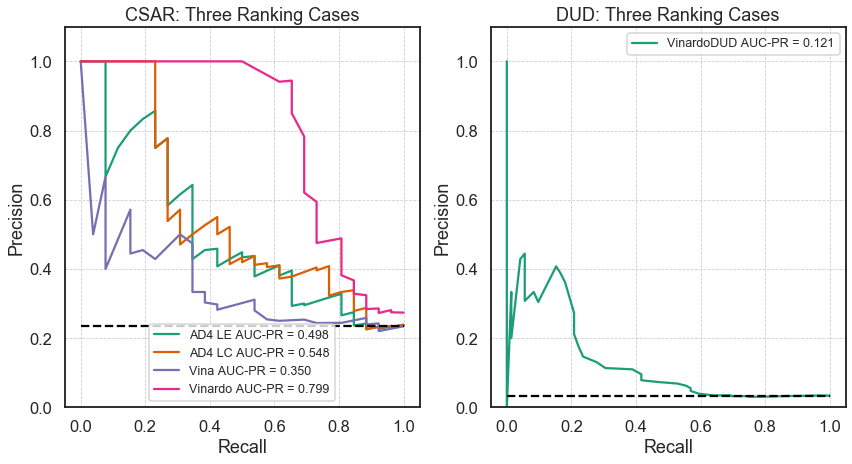

In [20]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_dockings.plot_pr_auc(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_pr_auc(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

## Factor de Enriquecimiento

### Enrichment Factor

- El factor de enriquecimiento se basa determinar cuantas de las $n$ moléculas activas se encuentran dentro de una fracción inicial, de tamaño $\chi$, del *ranking* de los valores predichos. 

- Esto permite resolver el problema de comparar reultados del clasificador sobre datasets con diferentes proporciones de activos e inactivos. **Pero con el mismo número de moléculas $N$**.

- La idea es comparar qué tan enriquecido en activos está la primer fracción (de tamaño $\chi$) de **mi *ranking* de predichos**, con respecto al enriquecimiento de una fracción del mismo tamaño cuyos elementos se eligieron aleatoriamente.
- $EF$ sí puede discriminar entre los tres casos mencionados anteriormente.

Del artículo de Truchon y Bayly:
> *This metric has the advantage of answering the question: how enriched in actives will the set of 300 compounds that I select for screening be compared to the case where I would just pick the 300 compounds randomly? This is relevant only if the database is of considerable size (N > 300).*

La fórmula que presenta Truchon y Bayly es la siguiente:

> $
\begin{align}
EF_{\chi} = \frac{1}{\chi n}\sum_{i=1}^{n}\delta _i
\end{align}
$

donde $EF_{\chi}$ es el factor de enriquecimiento en la proporción $\chi$, $n$ es el número total de activos, y:
> - $\delta _i = 1$ si $r_i \leq \chi N$
- $\delta _i = 0$ si $r_i > \chi N$  
donde $r_i$ es la posición del activo $i$ en el ranking de los predichos.

Por lo tanto, $\sum_{i=1}^{n}\delta _i = n_s$, donde $n_s$ representa al número de moléculas activas dentro de las  $N_s =  \left \lfloor{\chi N}\right \rfloor $ moléculas del ranking:

> $
\begin{align}
EF_{\chi} = \frac{n_s}{\chi n}
\end{align}
$

Como $\chi = N_s/N$, llegamos al a fórmula mencionada por Lopes, *et al.*:

> $
\begin{align}
EF_{\chi} = \frac{n_s}{\chi n} = \frac{n_s*N}{N_s*n}
\end{align}
$

Otra manera de plantearlo es la siguiente:

> $
\begin{align}
EF_{X\%} = \frac{\textrm{# de activos a un X%}} {\textrm{# de moléculas a un X%}} * \frac{N}{n}
\end{align}
$

### Características del EF

- $\chi$ (o $X\%$) debe ser establecido por el investigador.

- El valor máximo que puede tomar es $1/\chi$ si $\chi \geq n/N$, o $N/n$ si $\chi < n/N$.Y su valor mínimo es 0.

- El valor medio de EF en una distribución uniforme se mantiene cercano a 1 ($\left \lfloor{\chi N}\right \rfloor/chi·N$).

### Desventajas:
- $EF$ se ve afectado por la proporción de activos en el *dataset* presentando un efecto de saturación. Con lo cual, cuando muy pocos activos en el dataset la métrica se vuelve muy sensible a pequeñas variaciones en las posiciones de los activos dentro de la fracción $\chi$.

- $EF$ además, otorga el mismo peso a los activos dentro de $N_s$, con lo cual no sería capaz de encontar diferencias entre los siguientes dos rankings de ejemplo:

> 1. (1, 1, 0, 0, 0 | ... ),  ranking 1 con $N_s = 5$ y $n_s = 2$
2. (0, 0, 0, 1, 1 | ... ),  ranking 2 con $N_s = 5$ y $n_s = 2$

- Esto se debe a que EF da el mismo peso a todos los ligandos activos que se encuentren dentro de la fracción $\chi$.

- Lo anterior dificulta que el $EF$ sea capaz de distinguir entre buenos clasificadores y excelentes clasificadores ([Truchon J-F, Bayly CI]()).

- EF además no tiene un valor máximo definido.

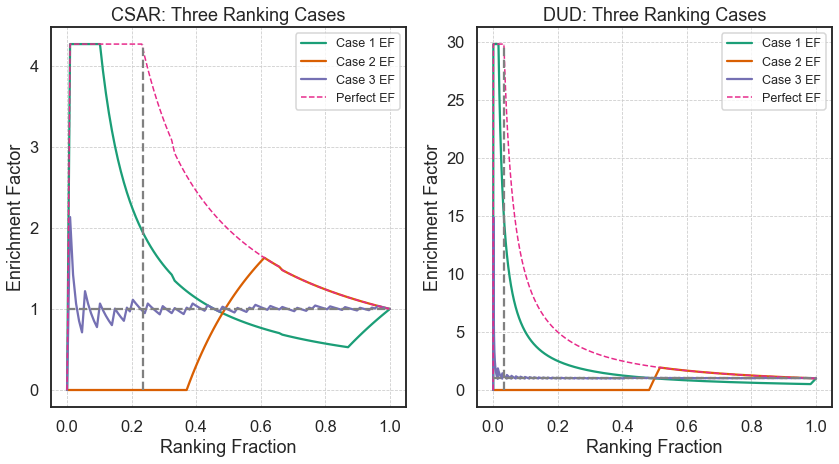

In [21]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_ef_auc(title='CSAR: Three Ranking Cases', method = 'absolute',
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_ef_auc(title='DUD: Three Ranking Cases', method = 'absolute',
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

## Normalized Enrichment Factor

- [Liu, et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6351977/) y [Lopes, *et al.* (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5289935/) mencionan una alternativa para normalizar el valor de EF y limitar su valor entre 0 y 1:

> $
\begin{align}
NEF_{\chi} = \frac{EF}{EF_{max}}
= \frac{n_s/(n*\chi)}{min(N_s, n) / (n*\chi)} = \frac{n_s} {min(N_s, n)}
\end{align}
$

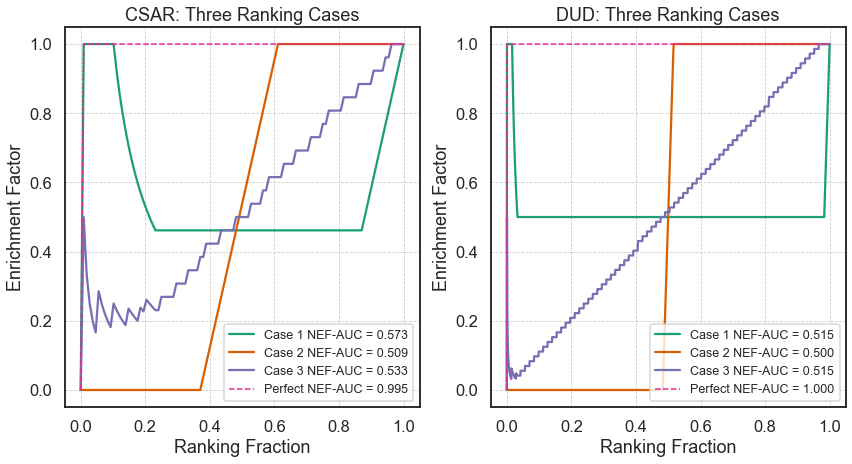

In [22]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_ef_auc(title='CSAR: Three Ranking Cases', method = 'normalized',
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_ef_auc(title='DUD: Three Ranking Cases', method = 'normalized',
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

In [23]:
print('Normalized Enrichment Factor CSAR')
fractions = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
csar_cases.get_efs(method = 'normalized', fractions=fractions)
print('Normalized Enrichment Factor DUD')
dud_cases.get_efs(method = 'normalized', fractions=fractions)

Normalized Enrichment Factor CSAR


,Case 1,Case 2,Case 3,Perfect,#ligs at X%
NEF at 0.5%,0.00,0.0,0.00,0.0,0.0
NEF at 1.0%,1.00,0.0,0.50,1.0,1.0
NEF at 2.0%,1.00,0.0,0.33,1.0,2.0
NEF at 5.0%,1.00,0.0,0.17,1.0,5.0
NEF at 10.0%,1.00,0.0,0.25,1.0,11.0
NEF at 20.0%,0.52,0.0,0.26,1.0,22.0


Normalized Enrichment Factor DUD


,Case 1,Case 2,Case 3,Perfect,#ligs at X%
NEF at 0.5%,1.00,0.0,0.09,1.0,10.0
NEF at 1.0%,1.00,0.0,0.05,1.0,21.0
NEF at 2.0%,0.84,0.0,0.05,1.0,42.0
NEF at 5.0%,0.50,0.0,0.06,1.0,107.0
NEF at 10.0%,0.50,0.0,0.11,1.0,214.0
NEF at 20.0%,0.50,0.0,0.21,1.0,429.0


### Limitando la fracción evaluada

En las siguientes gráficas sólo se obtiene EF hasta $\chi = 0.1$.

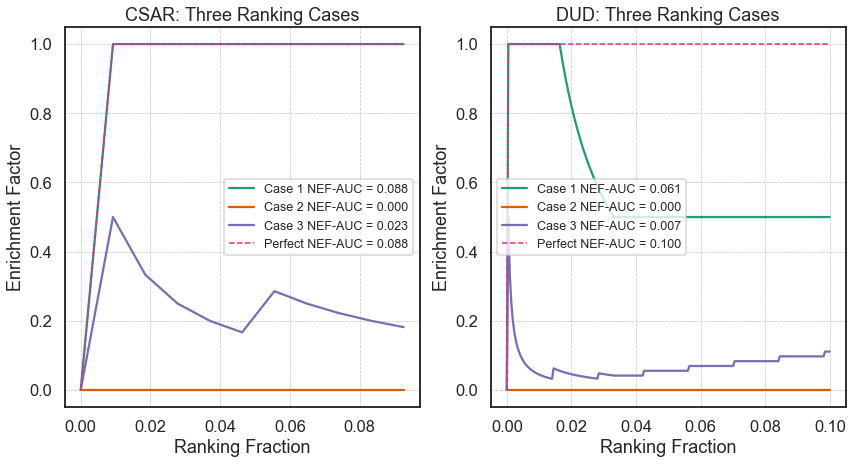

In [24]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_ef_auc(title='CSAR: Three Ranking Cases', 
                       method = 'normalized', max_chi = 0.1,
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_ef_auc(title='DUD: Three Ranking Cases', 
                      method = 'normalized', max_chi = 0.1,
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

## Limitando el número de ligandos en el top del ranking

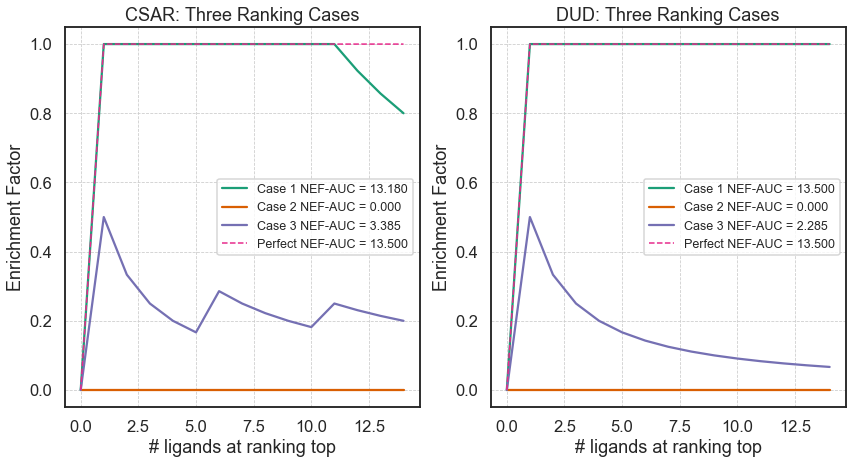

In [25]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_ef_auc(title='CSAR: Three Ranking Cases',
                       key_to_fade = 'Perfect',
                       method = 'normalized', max_num_of_ligands = 15,
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_ef_auc(title='DUD: Three Ranking Cases',
                      key_to_fade = 'Perfect',
                      method = 'normalized', max_num_of_ligands = 15, 
                      fontsize='x-small', show_by_itself = False)
plt.show();

### Para los resultados de docking

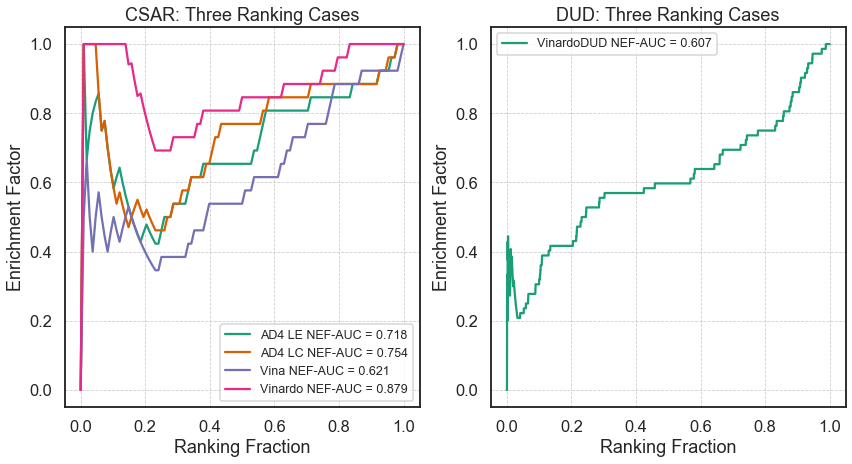

In [26]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_dockings.plot_ef_auc(title='CSAR: Three Ranking Cases', method = 'normalized',
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_ef_auc(title='DUD: Three Ranking Cases', method = 'normalized',
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

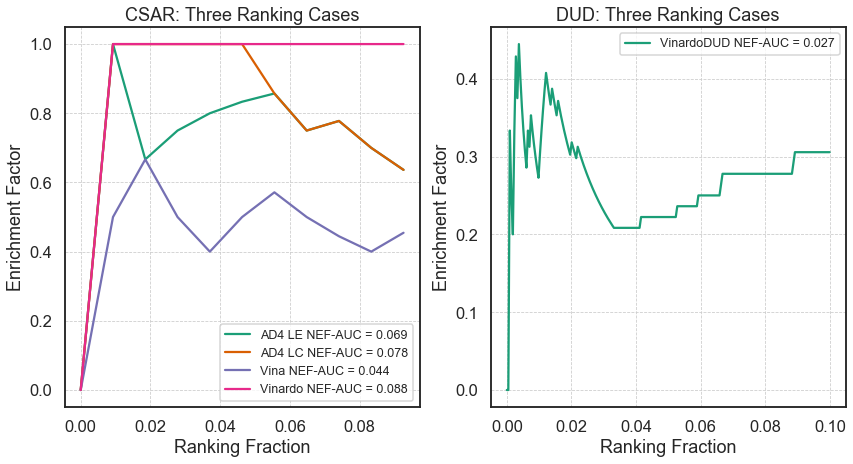

In [27]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_dockings.plot_ef_auc(title='CSAR: Three Ranking Cases', 
                       method = 'normalized', max_chi = 0.1,
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_ef_auc(title='DUD: Three Ranking Cases', 
                      method = 'normalized', max_chi = 0.1,
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

***

## Robust Initial Enhancement

- RIE es una métrica desarrolada por Sheridan, *et al*.  

- Se basa en decrementar el peso que tiene cada uno de los activos en el *ranking* de predichos conforme se alejan de las posiciones iniciales. Por lo tanto, su peso depende de su posición ($r_i$). Así, los activos que aparecen más pronto en el rango ('*early recognition*') tienen mayor peso en valor de la métrica.

- Para el valor de los pesos se utiliza una función exponencial.

- Es menos suceptible que $EF$ a tener grandes variaciones cuando la proporción de activos es muy baja.

La formula inicialmente propuesta es:

> $
\begin{align}
RIE = \frac{\sum_{i=1}^n e^{-\alpha r_i / N}} {\langle\sum_{i=1}^n e^{-\alpha r_i / N} \rangle_r},
\end{align}
$


> donde $n$ es el número de activos, $N$ es el número total de moléculas, $r_i$ es el rango de la $ith$ molécula activa en la lista ordenada de *predichos*. Algunas veces $r_i / N$ es expresado como $x_i$; el rango relativo o normalizado. Finalmente $\alpha$ es un hiperparámetro relacionado con $\chi$ del $EF$ ($1/\alpha \approx \chi$).

En la ecuación anteriror, el denominador es el promedio de la suma del exponencial cuando un número $n$ de activos  está uniformemente distribuido en $N$ moléculas. Este término inicialmente era calculado con MonteCarlo, pues obtenerlo por fuerza bruta implicaba tomar en cuenta las $N!/(N-n)!n!$ combinaciones posibles. No obstante,  Truchon y Bayly proponen la siguiente formula para calcular $RIE$:

> $
\begin{align}
RIE = \frac{\sum_{i=1}^n e^{-\alpha r_i / N}} {\frac{n}{N} \left( \frac{1 - e^{-\alpha}}{e^{\alpha / N} - 1}\right) },
\end{align}
$

> donde el nuevo denominador fue determinado por Truchon y Bayly de forma analítica para aproximarse al término de la primera ecuación.

- Al dar peso a todos los activos, $RIE$ tiene la ventaja sobre $EF$ de incluir la contribución de todos los activos en el score final (aunque mermando el peso de los activos que tienen posiciones más bajas en el *ranking*) .

- Sus valores mínimos y máximos dependen de $n$, $N$ y $\alpha$, con lo cual no permite comparaciones con *datasets* de diferentes tamaños, como sí lo hace $EF$.

- En resumen, $RIE$ tiene mayor ventaja que $ROC-AUC$ al abordar el problema de *early recognition*, y más ventaja sobre $REF$ al incluir la contribución de activos en todo el *ranking*, y no sólo en la fracción elegida. No obstante, si se van a comparar resultados con *datasets* de distinta proporción de activos/inactivos, $REF$ es una mejor opción.

Fuentes: https://sci-hub.tw/10.1021/ci600426e
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-10-225

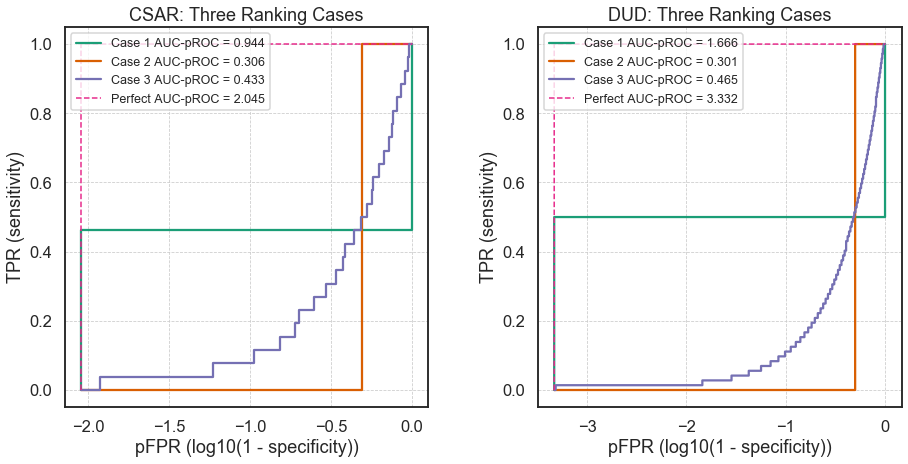

In [28]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_cases.plot_pRoc_auc(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                        fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_pRoc_auc(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.show();

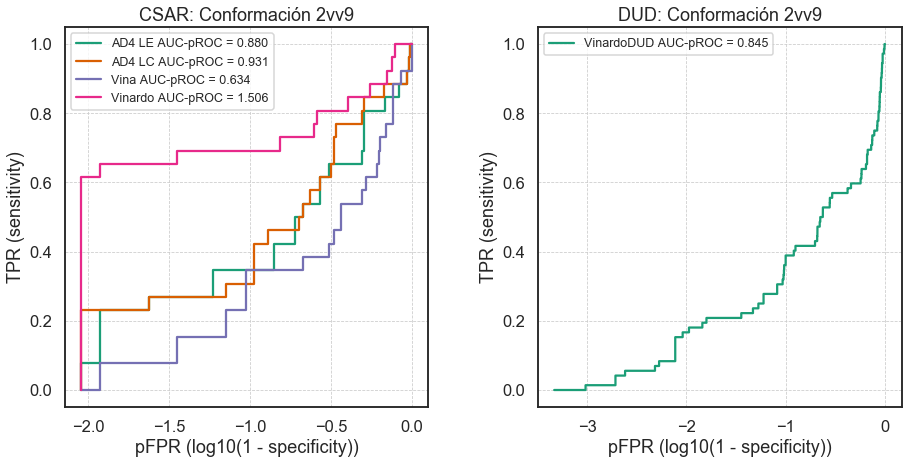

In [29]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_dockings.plot_pRoc_auc(title='CSAR: Conformación 2vv9',
                        fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_pRoc_auc(title='DUD: Conformación 2vv9',
                       fontsize='x-small', show_by_itself = False)
plt.show();

In [30]:
dud_dockings.y_pred_dict

{'VinardoDUD': array([8.8, 7.3, 8.7, ..., 7.2, 9.3, 8.1])}

In [31]:
fpr, tpr = dud_dockings._get_roc(dud_dockings.y_pred_dict['VinardoDUD'])

In [32]:
np.log10(1000)

3.0

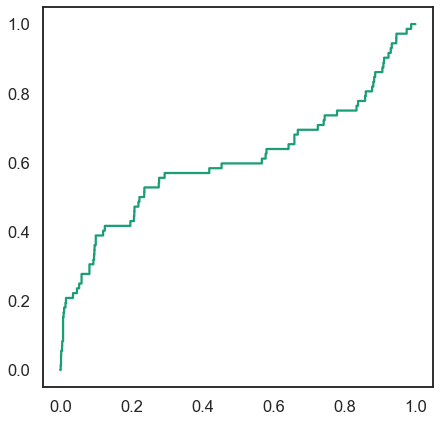

In [33]:
plt.plot(fpr, tpr)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


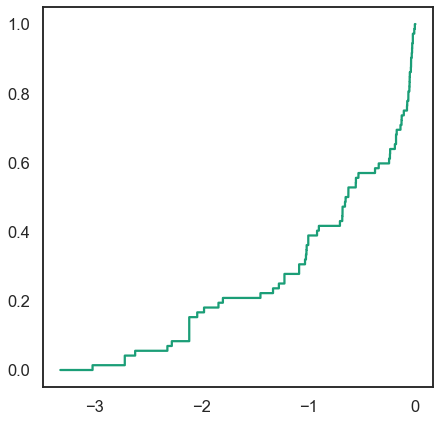

In [34]:
n = 72
pfpr = - np.log10(1/fpr)
plt.plot(pfpr, tpr)

In [35]:
fpr

array([0.00000000e+00, 4.82160077e-04, 9.64320154e-04, ...,
       9.99035680e-01, 9.99517840e-01, 1.00000000e+00])

In [36]:
- np.log10(fpr*72)/72

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


array([        inf,  0.0202705 ,  0.01608953, ..., -0.02579047,
       -0.02579338, -0.02579628])